In [1]:
#| default_exp visualize

# Visualize

> API details.

In [2]:
#|hide
from nbdev.showdoc import show_doc

In [3]:
#| export
from avcv._imports import *

In [4]:
#| export
def plot_images(images,
                labels=None,
                cls_true=None,
                cls_pred=None,
                space=(0.3, 0.3),
                mxn=None,
                size=(5, 5),
                dpi=300,
                max_w=1500,
                out_file=None,
                cmap='binary'):

    if mxn is None:
        # n = max(max_w // max([img.shape[1] for img in images]), 1)
        n = int(np.sqrt(len(images)))
        n = min(n, len(images))
        m = len(images) // n
        m = max(1, m)
        mxn = (m, n)
        logger.info(f"Grid size: {mxn}")

    fig, axes = plt.subplots(*mxn)
    fig.subplots_adjust(hspace=space[0], wspace=space[1])
    fig.figsize = size
    fig.dpi = dpi
    for i, ax in enumerate(axes.flat):
        if i < len(images):
            ax.imshow(images[i], cmap=cmap)
            if labels is not None:
                xlabel = labels[i]
            elif cls_pred is None and cls_true is not None:
                xlabel = "True: {0}".format(cls_true[i])
            elif cls_pred is None and cls_true is not None:
                xlabel = "True: {0}, Pred: {1}".format(cls_true[i],
                                                       cls_pred[i])
            else:
                xlabel = None
            if xlabel is not None:
                ax.set_xlabel(xlabel)
            ax.set_xticks([])
            ax.set_yticks([])
    if out_file is None:
        plt.show()
    else:
        plt.savefig(out_file)
        logger.info('Save fig:', out_file)
        plt.close()


def _to_bchw(tensor, format):
    if 'b' in format:
        if 'c' in format:
            target = 'bchw'
        else:
            target = 'bhwc'
        tensor = torch.einsum(f'{format}->{target}', tensor)
        if target == 'bhwc':
            tensor = tensor.permute(0, 3, 1, 2)  # bhwc -> bchw
    else:
        if 'c' in format:
            target = 'chw'
            tensor = torch.einsum(f'{format}->{target}', tensor)
            tensor = tensor.unsqueeze(0)  # add batch dimension
        else:
            tensor = tensor.unsqueeze(0).unsqueeze(0)  # add batch and channel dimensions
    
    return tensor


def _detect_format(tensor):
    tensor_shape = tensor.shape
    ndim = len(tensor_shape)

    if ndim == 2:
        return "hw"
    elif ndim == 3:
        if 3 in tensor_shape or 1 in tensor_shape:
            if tensor_shape[-1] in (3, 1):
                return "hwc"
            elif tensor_shape[0] in (3, 1):
                return "chw"
        else:
            if tensor_shape[0] < tensor_shape[1] and tensor_shape[0] < tensor_shape[2]:
                return "bhw"
            else:
                return "HWB"
    elif ndim == 4:
        if tensor_shape[1] in (3, 1):
            return "BCHW"
        elif tensor_shape[3] in (3, 1):
            return "BHWC"
        elif tensor_shape[0] in (3, 1):
            return "CBHW"
        else:
            print(tensor.shape)
            raise
    else:
        raise




def tensor_to_image(img_tensor, to_pil=False):

    def _to_grid(bchw):
        # Ensure input is BCHW format
        assert len(bchw.shape) == 4, "Input array must be BCHW format"
        
        # Convert numpy array to torch tensor if necessary
        if isinstance(bchw, np.ndarray):
            bchw = torch.from_numpy(bchw)
        
        from torchvision.utils import make_grid

        # Use make_grid function
        grid = make_grid(bchw, nrow=int(math.sqrt(bchw.shape[0])), padding=0)
        
        # Convert to HWC format and return as numpy array
        return grid.permute(1, 2, 0).cpu().numpy()
    import torch
    def handle_range(img_tensor):    
        min_val, max_val = img_tensor.min(), img_tensor.max()
        if 0 <= min_val and max_val <= 1:
            img_tensor = (img_tensor * 255).round()
        elif min_val < 0 or max_val > 255:
            img_tensor = ((img_tensor - min_val) / (max_val - min_val) * 255).round()
        
        return img_tensor

    if isinstance(img_tensor, np.ndarray): 
        img_tensor = torch.from_numpy(img_tensor)

    format = _detect_format(img_tensor).lower()
    bchw = _to_bchw(img_tensor, format).cpu().numpy()
    img_tensor = _to_grid(bchw)
    
    img_tensor = handle_range(img_tensor)
    
    if img_tensor.ndim == 2:
        img_tensor = np.stack([img_tensor] * 3, axis=-1)
    elif img_tensor.shape[-1] == 1:
        img_tensor = np.concatenate([img_tensor] * 3, axis=-1)
    
    img_tensor =  img_tensor.astype(np.uint8)
    if to_pil:
        img_tensor = Image.fromarray(img_tensor)
    return img_tensor


def imshow(inp,  dpi=100, size=10, cmap='gray', out_file=None, auto_convert_input=True):
    """
        Input: either a path or image
    """
    if auto_convert_input:
        inp = tensor_to_image(inp)
    if len(inp.shape) == 4:
        inp = inp[0]
    inp = np.squeeze(inp)
    if type(inp) is str:
        assert os.path.exists(inp)
        inp = cv2.imread(inp)
    if size is None:
        size = max(5, inp.shape[1] // 65)
    plt.figure(figsize=(size, size), dpi=dpi)
    plt.imshow(inp, cmap=cmap)
    if out_file is None:
        plt.show()
    else:
        plt.savefig(out_file)
    plt.close()

In [5]:
#| hide
img = np.zeros([100, 100, 3], dtype='uint8')
img[...,0] = 100
show(img, dpi=10)


NameError: name 'show' is not defined

In [ ]:
show_doc(plot_images)
show_doc(imshow)

---

### imshow

>      imshow (inp, dpi=100, size=10, cmap='gray', out_file=None,
>              auto_convert_input=True)

*Input: either a path or image*

## Tensor2images

In [ ]:
#| export

def tensor2imgs(tensor, mode='bhwc', 
                    mean=(123.675, 116.28, 103.53), std= (58.395, 57.120000000000005, 57.375), **kwargs):
    tensor = tensor.cpu()
    if mode == 'bhwc':
        tensor = tensor.permute([0,3,1,2])
        return tensor2imgs(tensor, mode='bchw',std=std, mean=mean)
    if mode == 'hwc':
        tensor = tensor[None].permute([0,3,1,2])
        return tensor2imgs(tensor, mode='bchw', std=std, mean=mean)[0]
    if mode == 'chw':
        tensor = tensor[None]
        return tensor2imgs(tensor, mode='bchw', std=std, mean=mean)[0]
    return mmcv.tensor2imgs(tensor, mean=mean, std=std, **kwargs)

In [ ]:
#| hide
tensor = torch.randn([2,3,100,100])
imgs = tensor2imgs(tensor, 'bchw')

## Visualize bbox
### Box visuialize

In [ ]:
#| export
COCO_COLORS = np.array(
    [
        0.000, 0.447, 0.741,
        0.850, 0.325, 0.098,
        0.929, 0.694, 0.125,
        0.494, 0.184, 0.556,
        0.466, 0.674, 0.188,
        0.301, 0.745, 0.933,
        0.635, 0.078, 0.184,
        0.300, 0.300, 0.300,
        0.600, 0.600, 0.600,
        1.000, 0.000, 0.000,
        1.000, 0.500, 0.000,
        0.749, 0.749, 0.000,
        0.000, 1.000, 0.000,
        0.000, 0.000, 1.000,
        0.667, 0.000, 1.000,
        0.333, 0.333, 0.000,
        0.333, 0.667, 0.000,
        0.333, 1.000, 0.000,
        0.667, 0.333, 0.000,
        0.667, 0.667, 0.000,
        0.667, 1.000, 0.000,
        1.000, 0.333, 0.000,
        1.000, 0.667, 0.000,
        1.000, 1.000, 0.000,
        0.000, 0.333, 0.500,
        0.000, 0.667, 0.500,
        0.000, 1.000, 0.500,
        0.333, 0.000, 0.500,
        0.333, 0.333, 0.500,
        0.333, 0.667, 0.500,
        0.333, 1.000, 0.500,
        0.667, 0.000, 0.500,
        0.667, 0.333, 0.500,
        0.667, 0.667, 0.500,
        0.667, 1.000, 0.500,
        1.000, 0.000, 0.500,
        1.000, 0.333, 0.500,
        1.000, 0.667, 0.500,
        1.000, 1.000, 0.500,
        0.000, 0.333, 1.000,
        0.000, 0.667, 1.000,
        0.000, 1.000, 1.000,
        0.333, 0.000, 1.000,
        0.333, 0.333, 1.000,
        0.333, 0.667, 1.000,
        0.333, 1.000, 1.000,
        0.667, 0.000, 1.000,
        0.667, 0.333, 1.000,
        0.667, 0.667, 1.000,
        0.667, 1.000, 1.000,
        1.000, 0.000, 1.000,
        1.000, 0.333, 1.000,
        1.000, 0.667, 1.000,
        0.333, 0.000, 0.000,
        0.500, 0.000, 0.000,
        0.667, 0.000, 0.000,
        0.833, 0.000, 0.000,
        1.000, 0.000, 0.000,
        0.000, 0.167, 0.000,
        0.000, 0.333, 0.000,
        0.000, 0.500, 0.000,
        0.000, 0.667, 0.000,
        0.000, 0.833, 0.000,
        0.000, 1.000, 0.000,
        0.000, 0.000, 0.167,
        0.000, 0.000, 0.333,
        0.000, 0.000, 0.500,
        0.000, 0.000, 0.667,
        0.000, 0.000, 0.833,
        0.000, 0.000, 1.000,
        0.000, 0.000, 0.000,
        0.143, 0.143, 0.143,
        0.286, 0.286, 0.286,
        0.429, 0.429, 0.429,
        0.571, 0.571, 0.571,
        0.714, 0.714, 0.714,
        0.857, 0.857, 0.857,
        0.000, 0.447, 0.741,
        0.314, 0.717, 0.741,
        0.50, 0.5, 0
    ]
).astype(np.float32).reshape(-1, 3)

def bbox_visualize(img, boxes, scores, cls_ids, conf=0.5, class_names=None, texts=None, box_color=None):
    img = img.copy()
    for i in range(len(boxes)):
        box = boxes[i]
        cls_id = int(cls_ids[i])
        score = scores[i]
        if score < conf:
            continue
        x0 = int(box[0])
        y0 = int(box[1])
        x1 = int(box[2])
        y1 = int(box[3])
        if box_color is None:
            
            color_id = cls_id % len(COCO_COLORS)
            _color = COCO_COLORS[color_id]
        else:
            _color = np.array(box_color)/255.
            
        color = (_color * 255).astype(np.uint8).tolist()

        txt_color = (0, 0, 0) if np.mean(_color) > 0.5 else (255, 255, 255)
        txt_bk_color = (_color * 255 * 0.7).astype(np.uint8).tolist()

            
            
        if texts is None:
            text = '{}:{:.1f}%'.format(class_names[cls_id], score * 100)
        else:
            text = texts[i]
        
        font = cv2.FONT_HERSHEY_SIMPLEX

        txt_size = cv2.getTextSize(text, font, 0.4, 1)[0]
        cv2.rectangle(img, (x0, y0), (x1, y1), color, 2)

        
        cv2.rectangle(
            img,
            (x0, y0 + 1),
            (x0 + txt_size[0] + 1, y0 + int(1.5*txt_size[1])),
            txt_bk_color,
            -1
        )
        cv2.putText(img, text, (x0, y0 + txt_size[1]), font, 0.4, txt_color, thickness=1)

    return img

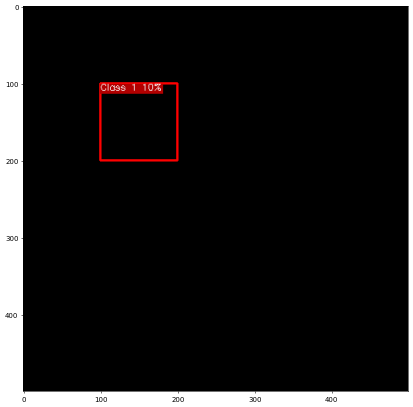

In [ ]:
show_doc(bbox_visualize)
# demo
img = np.zeros([500, 500,3], 'uint8')
bboxes = [[100,100, 200, 200]]
scores = [1]
cls_ids = [0]
# class_names = ['test']
texts = ['Class 1 10%']

vis = bbox_visualize(img, bboxes, scores,cls_ids, texts=texts, box_color=(255,0,0))
imshow(vis, dpi=50)

# Board

In [ ]:
#|export

class Board:
    """
        Example:
        board = Board()
        board.set_line_text(0, 'ok')
        board().show()
    """
    def __init__(self, num_lines=10, line_h=40, line_w = 300, font_scale=1, colors=None):
        colors = list(matplotlib.colors.ColorConverter.colors.keys())
        colors = np.array([matplotlib.colors.ColorConverter.to_rgb(c) for c in colors])
        colors = (colors*255).astype(int)        
        
        self.texts = ['' for _ in range(num_lines)]
        self.board_h = line_h*(num_lines+2)
        self.board_w = line_w
        self.line_h = line_h
        self.font_scale = 1
        self.colors = colors
        self.img_board = None
        if colors is None:
            self.colors = mplCOCO_COLORS[:num_lines]
    
    def draw(self):
        for i, text in enumerate(self.texts):
            color = self.colors[i].tolist()
            if isinstance(text, tuple):
                text, prob = text
                start_x = len(text)*23
                p1 = start_x, i*self.line_h+10
                p2 = start_x+int(prob * 100), (i+1)*self.line_h
                cv2.rectangle(self.board, p1, p2, color, -1)
                
                p1 = start_x, i*self.line_h+10
                p2 = start_x+100, (i+1)*self.line_h
                
                cv2.rectangle(self.board, p1, p2, (255,255,255), 1)
                
                cv2.putText(self.board, text, (0, p2[1]), cv2.FONT_HERSHEY_COMPLEX, 1, color)
                
            elif len(text):
                x = 0
                y = (i+1)*self.line_h
                cv2.putText(self.board, text, (x, y), cv2.FONT_HERSHEY_COMPLEX, 1, color)
        return self.board
    
    def set_line_text(self, line_idx, text, prob=None):
        if line_idx is None:
            if not hasattr(self, 'line_idx'):
                self.line_idx = 0
            else:
                self.line_idx += 1
            line_idx = self.line_idx
        if prob is not None:
            assert prob >=0 and prob <=1
            text = (text, prob)
        self.texts[line_idx] = text
    
    def clear(self):
        self.board = np.zeros([self.board_h, self.board_w, 3], 'uint8')
    
    def __call__(self):
        self.clear()
        self.draw()
        return self
    
    def show(self):
        show(self.board)
        

    def lazy_img_concat(self, img):
        # call the returned fuction to get the actual img_concat value
        self.img = img
        def f():
            self()
            board = self.board
            img = mmcv.imread(self.img)
            board = mmcv.imresize_like(board, img)
            return np.concatenate([img, board], 1)
        return f
    
    def img_concat(self, img):
        return self.lazy_img_concat(img)()

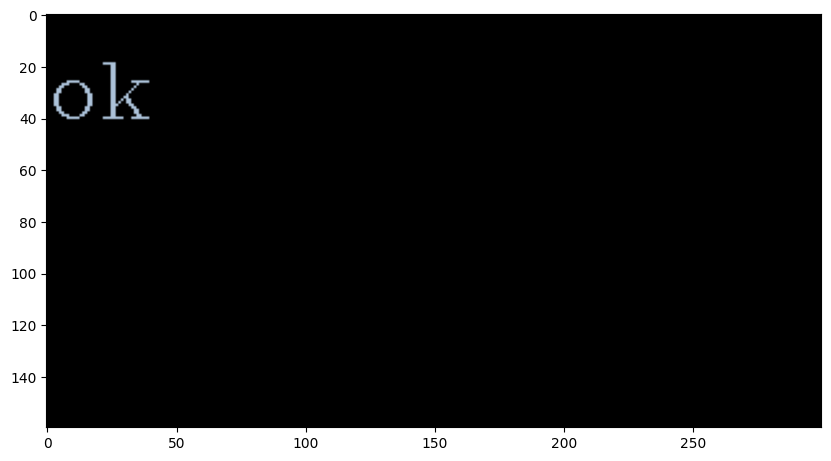

In [ ]:
#| hide
board = Board(2)
board.set_line_text(0, 'ok')
board().show()

In [6]:
!nbdev_export